# Feature Selection 2

### All Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
from glob import glob
from sklearn.metrics import r2_score, mean_squared_error
from word_list.basic import politics1, politics2
from word_list.basic import business, control
import statsmodels.formula.api as smf
from sklearn.model_selection import TimeSeriesSplit

In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felsal/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

## Variables

In [2]:
TRAIN_DATE_FIRST = "2004-01-04" 
TRAIN_DATE_LAST = "2012-12-16" 
INSTRUMENT = "es1"
INSTRUMENT_PRICE_COLUMN = 'PX_LAST'
INSTRUMENT_DATE_COLUMN = 'date'

### Functions

In [3]:
def get_merged_ts(feature_df,
                  feature_name,
                  target_ts,
                  target_name,
                  tolerance=pd.Timedelta("1d")):

    merged_df = pd.merge_asof(feature_df[feature_name].to_frame(),
                              target_ts,
                              left_index=True,
                              right_index=True,
                              tolerance=tolerance)
    merged_df = merged_df.dropna()
    merged_feature, merged_target = merged_df[feature_name],merged_df[target_name] 
    return merged_feature, merged_target

def show_results(results, top_n, number, ascending):

    display(Markdown("#### {}.1) Top {} Features".format(number, top_n)))
    display(HTML(results.head(top_n).to_html()))

    display(Markdown(""))

    display(Markdown("#### {}.2) Bottom {} Features".format(number, top_n)))
    display(HTML(results.tail(top_n).to_html()))

    display(Markdown(""))

    word_rank = results.groupby("word").mean(
    ).score.sort_values(ascending=ascending).to_frame()
    
    display(Markdown("#### {}.3) Top {} words".format(number, top_n)))
    display(HTML(word_rank.head(top_n).to_html()))
    display(Markdown("#### {}.4) Bottom {} words".format(number, top_n)))
    display(HTML(word_rank.tail(top_n).to_html()))

    politics1_rank = word_rank.loc[politics1].values.flatten()
    politics2_rank = word_rank.loc[politics2].values.flatten()

    # hack. We have a problem with the word "notability"
    politics2_rank = np.concatenate([politics2_rank, [float("nan")]])

    business_rank = word_rank.loc[business].values.flatten()
    control_rank = word_rank.loc[control].values.flatten()

    method_cat = np.stack([politics1_rank,
                           politics2_rank,
                           business_rank,
                           control_rank], 1)
    method_cat = pd.DataFrame(method_cat, columns=["Politics1",
                                                   "Politics2",
                                                   "Business",
                                                   "Control"])

    fig, ax = plt.subplots(figsize=(10, 5))
    results.score.hist(ax=ax)
    ax.set_title(
        "{}.5) Method {} score distribution".format(
            number,
            number),
        fontsize=18)

    fig, ax = plt.subplots(figsize=(10, 5))
    word_rank.score.hist(ax=ax)
    ax.set_title("{}.6) Method {} word score distribution".format(number,
                                                                  number), fontsize=18)

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=method_cat, orient="h", palette="Set2", ax=ax)
    ax.set_title("{}.7) Method {} score distribution for each category".format(number,
                                                                               number), fontsize=18)

def cv_lr_error_results(df,
                       feature_name,
                       target_name,
                       n_splits):
    all_results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(df):
        formula = "{} ~ {}".format(target_name, feature_name)
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        lr = smf.ols(formula=formula, data=df_train).fit()
        y_pred = lr.predict(df_test).values
        y_true = df_test[target_name].values
        result = np.stack([y_true,y_pred],1)
        test_results = pd.DataFrame(result,columns=[target_name,"prediction"], index=df_test.index) 
        all_results.append(test_results)
    return all_results

def get_results_over_time(results, target_name):
    obs = []
    for ts in results:
        date = ts.index[-1]
        error = mean_squared_error(ts[target_name], ts["prediction"])
        r2 = r2_score(ts[target_name], ts["prediction"])
        obs.append((date, error, r2))
    new_results = pd.DataFrame(obs,columns=["date", "MSE", "r2"])
    return new_results.set_index("date", drop=True)



## Loading market data and defining return variable

For a day $t$, and an instrument with price $P_t$, we define the target variable $R_t$ as the *simple return*:

\begin{equation}
R_t = \frac{(P_t - P_{t-1})}{P_{t-1}}
\end{equation}

### es1 target data (2004 - 2012)

,es1_returns
date,
2004-01-05,0.009919
2004-01-06,0.001782
2004-01-07,0.003123
2004-01-08,0.003556
2004-01-09,-0.008413


#### shape = (2273, 1)

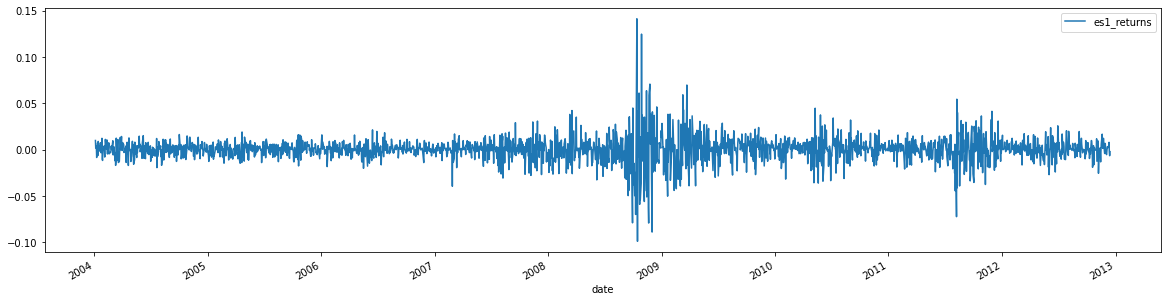

In [4]:
market_path = os.path.join('data','market',"{}.txt".format(INSTRUMENT))
df_market = pd.read_csv(market_path, sep='\t')
df_market.loc[:, INSTRUMENT_DATE_COLUMN] = pd.to_datetime(df_market[INSTRUMENT_DATE_COLUMN])
df_market = df_market.set_index(INSTRUMENT_DATE_COLUMN)
close = df_market[[INSTRUMENT_PRICE_COLUMN]].dropna()
target = close.pct_change().dropna()
target_name = "{}_returns".format(INSTRUMENT) 
target.columns = [target_name]
target = target[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]

display(Markdown("### {} target data ({} - {})".format(INSTRUMENT,
                                                       TRAIN_DATE_FIRST.split("-")[0],
                                                       TRAIN_DATE_LAST.split("-")[0])))
display(HTML(target.head(5).to_html()))
display(Markdown("#### shape = {}".format(target.shape)))
display(Markdown(" "))
fig, ax = plt.subplots(figsize=(20,5))
target.plot(ax=ax);

## Google trends data

Let ${S^{w}}_t$ be the search interest in the word $w$ at day $t$.

### Google trends data (2004 - 2012)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-04,1.0,1.0,18.0,26.0,57.0,5.0,0.0,6.0,6.0,51.0,81.0,17.0,84.0,51.0,26.0,10.0,1.0,3.0,68.0,27.0,3.0,50.0,18.0,4.0,1.0,3.0,0.0,13.0,10.0,67.0,27.0,10.0,53.0,3.0,7.0,5.0,7.0,8.0,2.0,19.0,31.0,2.0,1.0,1.0,0.0,5.0,3.0,4.0,1.0,4.0,1.0,18.0,4.0,3.0,29.0,5.0,17.0,13.0,4.0,0.0,61.0,1.0,1.0,8.0,18.0,4.0,2.0,23.0,46.0,12.0,30.0,21.0,2.0,1.0,8.0,12.0,1.0,55.0,1.0,21.0,100.0,86.0,11.0,43.0,28.0,9.0,1.0,1.0,8.0,3.0,8.0,14.0,26.0,13.0,46.0,11.0,1.0,2.0,14.0,5.0,26.0,25.0,9.0,3.0,19.0,26.0,43.0,6.0,3.0,5.0,3.0,3.0,20.0,29.0,3.0,83.0,2.0,1.0,62.0,60.0,24.0,3.0,1.0,41.0,26.0,32.0,10.0,2.0,2.0,3.0,10.0,27.0,2.0,31.0,5.0,7.0,2.0,5.0,38.0,24.0,1.0,7.0,7.0,14.0,35.0,6.0,6.0,4.0,30.0,11.0,6.0,2.0,1.0,79.0,38.0,22.0,21.0,32.0,8.0,26.0,6.0,3.0,24.0,21.0,70.0,8.0,9.0,26.0,0.0,57.0,10.0,37.0,16.0,1.0,56.0,1.0,1.0,1.0,60.0,68.0,48.0,34.0,1.0,29.0,87.0,85.0
2004-01-05,0.0,1.0,21.0,29.0,50.0,2.0,0.0,5.0,3.0,52.0,71.0,23.0,82.0,47.0,26.0,10.0,4.0,2.0,100.0,34.0,4.0,88.0,19.0,2.0,0.0,5.0,0.0,10.0,11.0,71.0,28.0,14.0,55.0,2.0,9.0,6.0,5.0,9.0,0.0,19.0,58.0,2.0,2.0,3.0,1.0,6.0,5.0,3.0,2.0,5.0,2.0,11.0,6.0,2.0,25.0,5.0,18.0,6.0,8.0,0.0,57.0,0.0,3.0,8.0,23.0,5.0,1.0,20.0,38.0,10.0,33.0,25.0,5.0,1.0,6.0,8.0,1.0,54.0,2.0,21.0,87.0,79.0,11.0,36.0,30.0,7.0,4.0,1.0,10.0,5.0,5.0,14.0,22.0,11.0,52.0,16.0,0.0,2.0,15.0,4.0,36.0,22.0,13.0,3.0,34.0,24.0,43.0,5.0,1.0,4.0,3.0,6.0,20.0,29.0,6.0,73.0,3.0,2.0,54.0,49.0,23.0,4.0,2.0,30.0,21.0,30.0,7.0,5.0,3.0,2.0,13.0,29.0,2.0,28.0,5.0,7.0,2.0,6.0,30.0,22.0,2.0,5.0,8.0,12.0,37.0,2.0,4.0,3.0,35.0,7.0,2.0,2.0,2.0,70.0,44.0,20.0,17.0,33.0,6.0,29.0,6.0,3.0,21.0,19.0,66.0,12.0,13.0,18.0,2.0,60.0,4.0,31.0,12.0,0.0,57.0,2.0,2.0,2.0,64.0,67.0,51.0,39.0,0.0,30.0,91.0,70.0
2004-01-06,0.0,2.0,31.0,30.0,87.0,7.0,0.0,4.0,4.0,86.0,66.0,27.0,78.0,57.0,26.0,11.0,3.0,2.0,89.0,32.0,9.0,87.0,32.0,3.0,1.0,1.0,1.0,37.0,19.0,96.0,48.0,10.0,74.0,3.0,13.0,5.0,7.0,7.0,1.0,33.0,62.0,2.0,2.0,1.0,1.0,10.0,7.0,6.0,1.0,7.0,2.0,24.0,8.0,6.0,54.0,16.0,36.0,8.0,7.0,2.0,62.0,1.0,2.0,7.0,17.0,4.0,1.0,21.0,62.0,19.0,23.0,36.0,6.0,1.0,11.0,10.0,1.0,94.0,2.0,28.0,87.0,85.0,12.0,50.0,56.0,14.0,2.0,2.0,10.0,4.0,9.0,16.0,16.0,16.0,66.0,22.0,0.0,3.0,13.0,10.0,59.0,32.0,21.0,5.0,17.0,34.0,42.0,6.0,3.0,5.0,1.0,6.0,25.0,27.0,4.0,45.0,3.0,2.0,100.0,82.0,27.0,2.0,1.0,36.0,34.0,35.0,12.0,4.0,5.0,2.0,18.0,37.0,5.0,38.0,3.0,5.0,4.0,7.0,47.0,15.0,2.0,11.0,8.0,17.0,24.0,10.0

#### shape = (3270, 186)

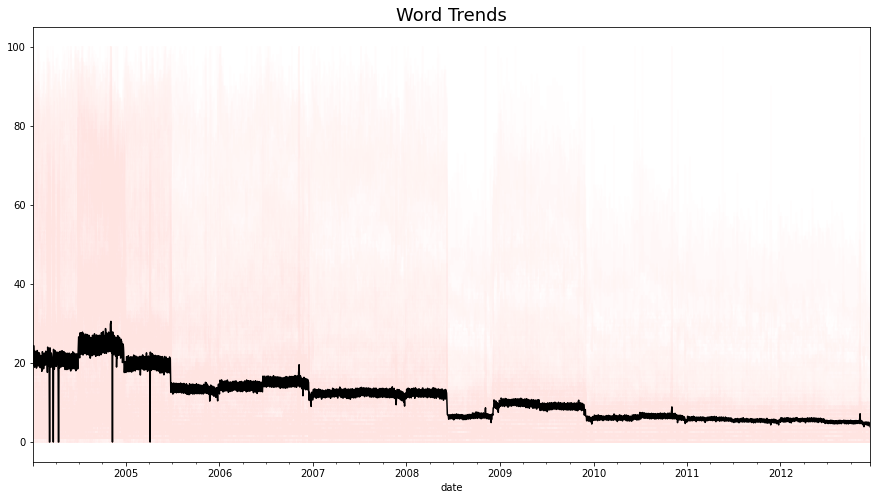

In [5]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_list = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_list.append(ts)

trends = pd.concat(trends_list,1)
trends = trends.fillna(0.0)
words = list(trends.columns)
words.sort()
words.remove("notability") # only zero info in this dataset
politics2 = [w for w in politics2 if w != "notability"] # only zero info in this dataset

trends = trends[words]
trends = trends[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]


display(Markdown("### Google trends data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

fig, ax = plt.subplots(figsize=(15,8))
trends.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trends", fontsize=18);

## Creating Features

For $k \in \{1, \dots, K\}$ and word $w$, we define the word feature ${D^{w}}_t$ as the $k$ difference:

\begin{equation}
{D^{w}}_{k,t} = {S^{w}}_t - {S^{w}}_{t-k}
\end{equation}


In [6]:
K = 30
features_list = []

for k in range(1, K+1):
    feat = trends.diff(k).add_suffix('_diff_{}'.format(k))
    features_list.append(feat)
    
trend_features = pd.concat(features_list, 1)

display(Markdown("### Word Features"))
display(HTML(trend_features.head(5).to_html()))
display(Markdown("#### shape = {}".format(trend_features.shape)))

### Word Features

#### shape = (3270, 5580)

## Method 1 Results

#### 1.1) Top 10 Features

,word,k,score
0,dow_jones,19,0.068673
1,election,21,0.061354
2,DOW_JONES,19,0.060716
3,debt,20,0.059229
4,DOW_JONES,7,0.059183
5,election,20,0.056165
6,food,3,0.054825
7,debt,13,0.053229
8,food,4,0.052650
9,election,27,0.052403


#### 1.2) Bottom 10 Features

,word,k,score
5570,investment,22,1.745550e-05
5571,success,22,1.719511e-05
5572,marketing,11,1.195299e-05
5573,portfolio,5,9.318088e-06
5574,act,25,9.186686e-06
5575,tourism,26,8.555287e-06
5576,economic,27,6.021531e-06
5577,products,6,1.870256e-06
5578,headlines,10,1.219433e-06
5579,council,19,7.812569e-07


#### 1.3) Top 10 words

,score
word,
holiday,0.027820
cash,0.025649
food,0.025138
markets,0.024905
election,0.023893
kentucky,0.023633
world,0.023051
debt,0.022984
risk,0.022044


#### 1.4) Bottom 10 words

,score
word,
tourism,0.006630
war,0.006588
ministry,0.006574
sell,0.006381
judge,0.006072
economy,0.005797
conty,0.005735
voters,0.005554
default,0.005516


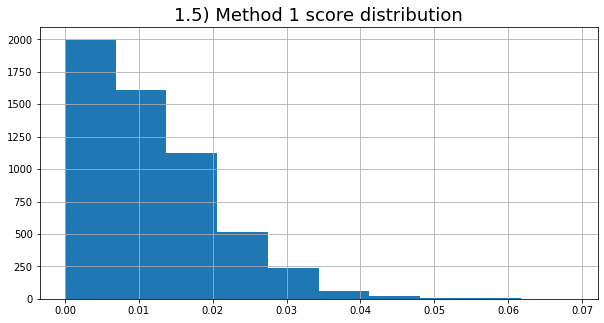

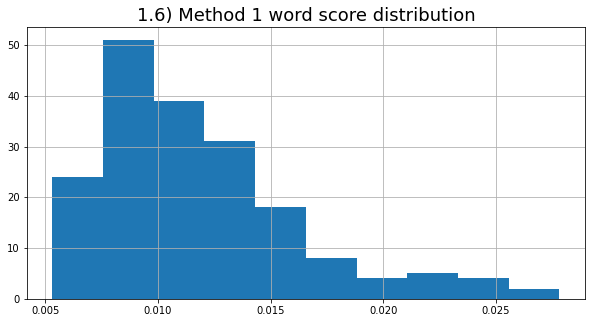

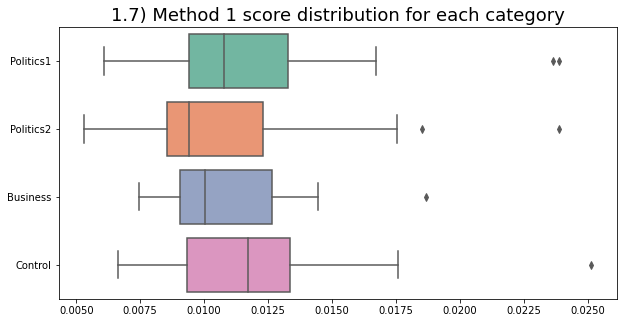

In [7]:
results1 = pd.read_csv("results/method_1.csv")
show_results(results1,10,1, ascending=False)

## Method 2 Results

### Method 2 Results with Lag

,word,k,lag,score
0,dow_jones,12,7,0.106202
1,DOW_JONES,12,7,0.103888
2,dow_jones,11,8,0.102046
3,DOW_JONES,21,7,0.101689
4,dow_jones,21,7,0.099045
5,dow_jones,8,8,0.098713
6,dow_jones,7,9,0.093934
7,DOW_JONES,11,8,0.090467
8,DOW_JONES,20,7,0.090199
9,dow_jones,20,7,0.087072


#### 2.1) Top 10 Features

,word,k,score
0,dow_jones,7,0.039700
1,dow_jones,13,0.038776
2,dow_jones,9,0.037487
3,DOW_JONES,7,0.037262
4,DOW_JONES,13,0.037182
5,DOW_JONES,19,0.036967
6,DOW_JONES,12,0.036916
7,dow_jones,12,0.036729
8,dow_jones,19,0.036066
9,dow_jones,8,0.036004


#### 2.2) Bottom 10 Features

,word,k,score
5570,development,28,0.004015
5571,gold,20,0.004005
5572,media,24,0.003877
5573,political,29,0.003761
5574,greed,20,0.003661
5575,greed,13,0.003597
5576,voters,18,0.003552
5577,hedge,21,0.003514
5578,voters,19,0.002915
5579,BUY_AND_HOLD,30,0.002859


#### 2.3) Top 10 words

,score
word,
dow_jones,0.030893
DOW_JONES,0.029828
debt,0.023290
election,0.022201
buy,0.020274
stock,0.020175
representatives,0.018479
holiday,0.018327
politics,0.017857


#### 2.4) Bottom 10 words

,score
word,
gold,0.007769
garden,0.007736
blacklist,0.007687
economy,0.007538
BUY_AND_HOLD,0.007280
judge,0.007217
republican,0.007216
greed,0.007205
voters,0.006573


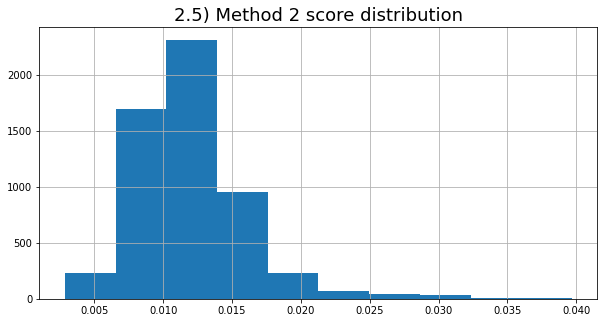

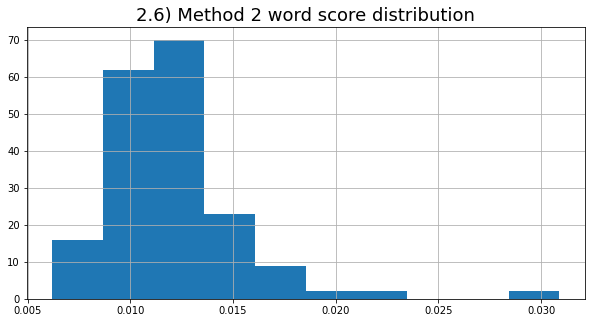

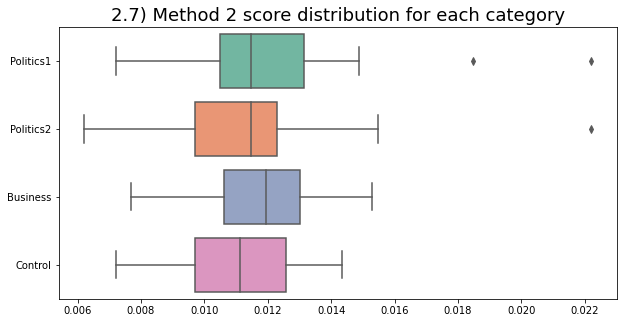

In [8]:
raw_results2 = pd.read_csv("results/method_2.csv")

raw_results2_s = raw_results2.set_index(["word", "k", "lag"]).sort_index()

results2 = []

for w in words:
    for k in range(1, K+1):
        score = raw_results2_s.xs((w,k)).mean()[0]
        obs = (w,k,score)
        results2.append(obs)

results2 = pd.DataFrame(results2, columns=["word","k","score"])
results2 = results2.sort_values("score",ascending=False)
results2 = results2.reset_index(drop=True)



display(Markdown("### Method 2 Results with Lag"))
display(HTML(raw_results2.head(10).to_html()))

show_results(results2,10,2,ascending=False)

## Method 3 Results

#### 3.1) Top 10 Features

,word,k,score
0,markets,4,0.000185
1,food,4,0.000185
2,kentucky,4,0.000185
3,food,3,0.000185
4,invest,3,0.000185
5,markets,10,0.000185
6,oil,6,0.000185
7,banking,7,0.000185
8,markets,2,0.000185
9,million,8,0.000185


#### 3.2) Bottom 10 Features

,word,k,score
5570,election,26,0.000187
5571,election,22,0.000187
5572,election,23,0.000187
5573,revenue,21,0.000187
5574,DOW_JONES,30,0.000187
5575,dow_jones,24,0.000187
5576,revenue,22,0.000187
5577,election,16,0.000187
5578,DOW_JONES,24,0.000187
5579,election,17,0.000187


#### 3.3) Top 10 words

,score
word,
markets,0.000186
holiday,0.000186
food,0.000186
debt,0.000186
cash,0.000186
religion,0.000186
leverage,0.000186
ceo,0.000186
kentucky,0.000186


#### 3.4) Bottom 10 words

,score
word,
nasdaq,0.000186
elected,0.000186
politics,0.000186
dow_jones,0.000186
elections,0.000186
votes,0.000186
president,0.000186
DOW_JONES,0.000186
revenue,0.000186


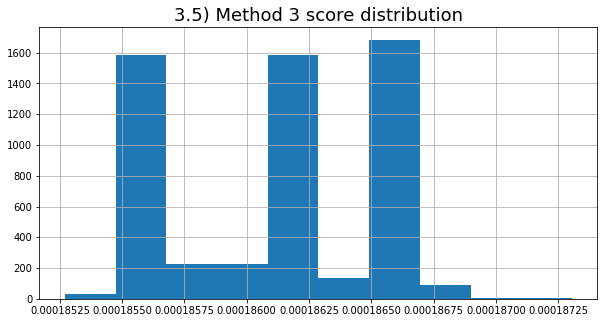

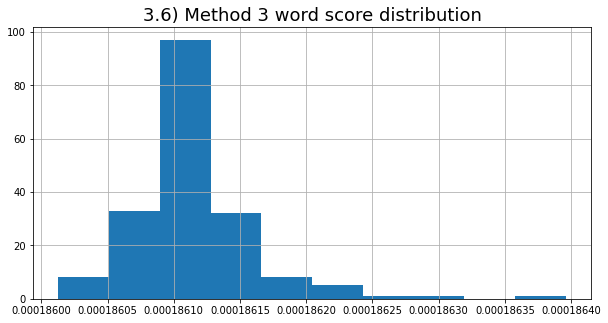

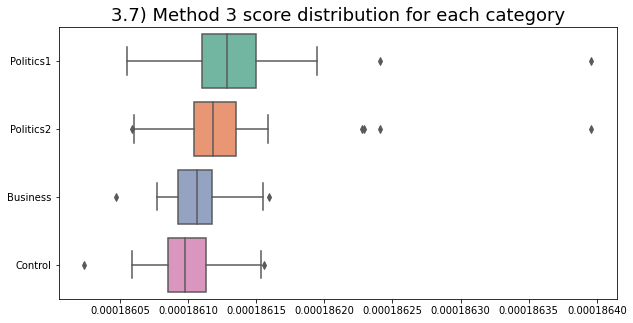

In [9]:
results3 = pd.read_csv("results/method_3.csv")
show_results(results3,10,3,ascending=True)

## Method 4 Results

### Method 4 Results with Lag

,word,k,lag,score
0,nasdaq,6,2,0.000185
1,finance,6,2,0.000185
2,metals,6,2,0.000185
3,nasdaq,7,2,0.000185
4,markets,4,1,0.000185
5,food,4,1,0.000185
6,nasdaq,5,2,0.000185
7,world,3,3,0.000185
8,nasdaq,8,2,0.000185
9,kentucky,4,1,0.000185


#### 4.1) Top 10 Features

,word,k,score
0,crash,1,0.000187
1,crisis,1,0.000187
2,gains,1,0.000187
3,environment,1,0.000187
4,color,1,0.000187
5,market,1,0.000187
6,fed,1,0.000187
7,BUY_AND_HOLD,1,0.000187
8,party,1,0.000187
9,winsconsin,1,0.000187


#### 4.2) Bottom 10 Features

,word,k,score
5570,happy,30,0.000188
5571,gain,30,0.000188
5572,unemployment,30,0.000188
5573,bank,30,0.000188
5574,dow_jones,30,0.000188
5575,DOW_JONES,24,0.000188
5576,county,30,0.000188
5577,DOW_JONES,30,0.000188
5578,election,30,0.000188
5579,dividend,30,0.000188


#### 4.3) Top 10 words

,score
word,
water,0.000187
arts,0.000187
consume,0.000187
movement,0.000187
religion,0.000187
BUY_AND_HOLD,0.000187
holiday,0.000187
william,0.000187
color,0.000187


#### 4.4) Bottom 10 words

,score
word,
president,0.000187
hedge,0.000187
revenue,0.000187
elected,0.000187
dividend,0.000187
unemployment,0.000187
county,0.000187
election,0.000187
dow_jones,0.000187


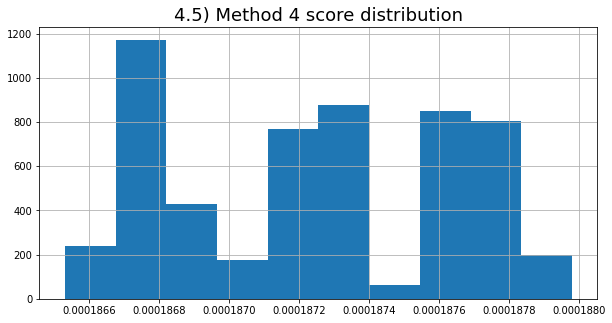

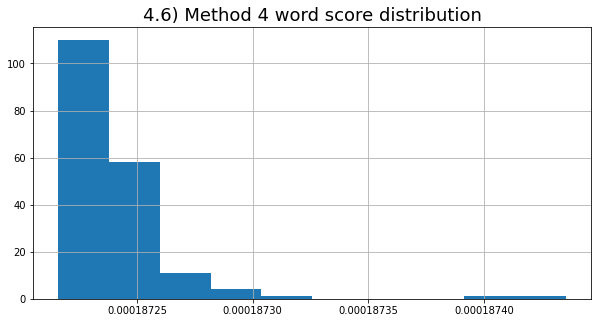

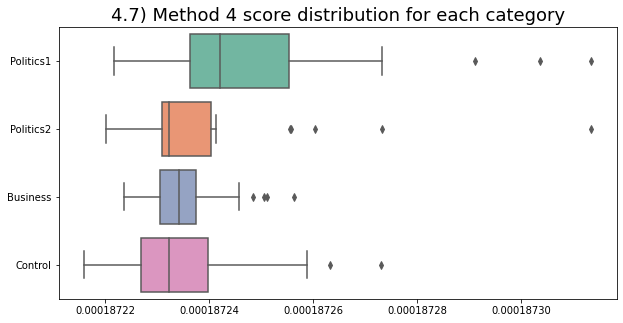

In [10]:
raw_results4 = pd.read_csv("results/method_4.csv")

raw_results4_s = raw_results4.set_index(["word", "k", "lag"]).sort_index()

results4 = []

for w in words:
    for k in range(1, K+1):
        score = raw_results4_s.xs((w,k)).mean()[0]
        obs = (w,k,score)
        results4.append(obs)

results4 = pd.DataFrame(results4, columns=["word","k","score"])
results4 = results4.sort_values("score",ascending=True)
results4 = results4.reset_index(drop=True)

display(Markdown("### Method 4 Results with Lag"))
display(HTML(raw_results4.head(10).to_html()))

show_results(results4,10,4,ascending=True)

## Model Evaluation

### 1)

\begin{align}
(\text{method }1)& \quad &\hat{R}_t = \beta_0 + \beta_1 D^{\text{dow_jones}}_{19, \,t-1}
\end{align}

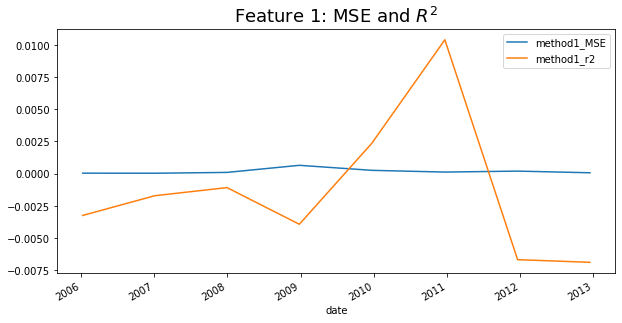

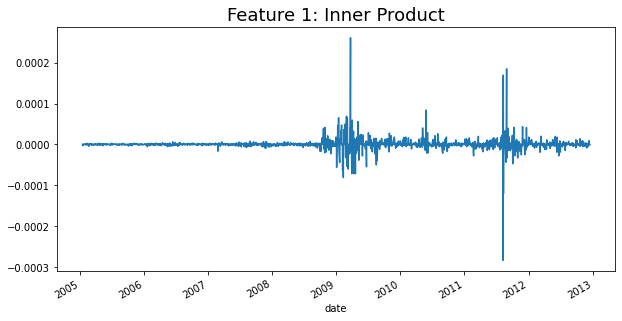

In [11]:
m_number = 1
w,k = "dow_jones", 19
shift = 1
n_splits = 8


feature_name = "{}_diff_{}".format(w,k)


f, t = get_merged_ts(feature_df=trend_features,
                     feature_name=feature_name,
                     target_ts=target,
                     target_name=target_name)
f = f.shift(shift)
merged_df = pd.concat([f,t],1)
test_results1 = cv_lr_error_results(df=merged_df.dropna(),
                                    feature_name=feature_name,
                                    target_name=target_name,
                                    n_splits=n_splits)

results_over_time1 = get_results_over_time(test_results1, target_name)
results_over_time1 = results_over_time1.add_prefix("method{}_".format(m_number))

fig, ax = plt.subplots(figsize=(10,5))
results_over_time1.plot(ax=ax);
ax.set_title(r"Feature {}: MSE and $R^2$".format(m_number), fontsize=18);

inner_product1 = pd.concat([res.prod(1) for res in test_results1])
fig, ax = plt.subplots(figsize=(10,5))
inner_product1.plot(ax=ax);
ax.set_title("Feature {}: Inner Product".format(m_number), fontsize=18);

### 2)

\begin{align}
(\text{method }2)& \quad &\hat{R}_t = \beta_0 + \beta_1 D^{\text{dow_jones}}_{12, \,t-7}
\end{align}




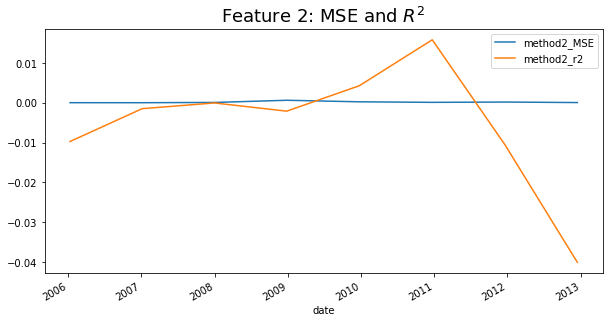

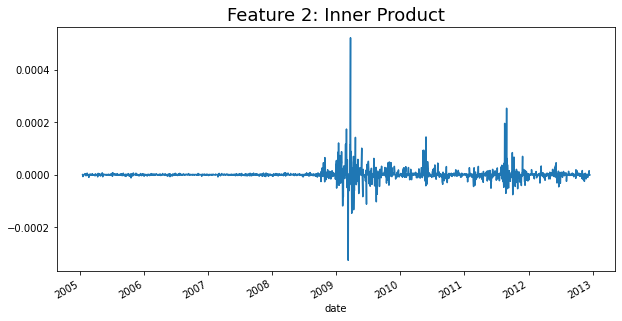

In [12]:
m_number = 2
w,k = "dow_jones", 12
shift = 7
n_splits = 8


feature_name = "{}_diff_{}".format(w,k)


f, t = get_merged_ts(feature_df=trend_features,
                     feature_name=feature_name,
                     target_ts=target,
                     target_name=target_name)
f = f.shift(shift)
merged_df = pd.concat([f,t],1)
test_results2 = cv_lr_error_results(df=merged_df.dropna(),
                                    feature_name=feature_name,
                                    target_name=target_name,
                                    n_splits=n_splits)

results_over_time2 = get_results_over_time(test_results2, target_name)
results_over_time2 = results_over_time2.add_prefix("method{}_".format(m_number))

fig, ax = plt.subplots(figsize=(10,5))
results_over_time2.plot(ax=ax);
ax.set_title(r"Feature {}: MSE and $R^2$".format(m_number), fontsize=18);

inner_product2 = pd.concat([res.prod(1) for res in test_results2])
fig, ax = plt.subplots(figsize=(10,5))
inner_product2.plot(ax=ax);
ax.set_title("Feature {}: Inner Product".format(m_number), fontsize=18);

### 3) 

\begin{align}
(\text{method }3)& \quad &\hat{R}_t = \beta_0 + \beta_1 D^{\text{markets}}_{4, \,t-1}
\end{align}

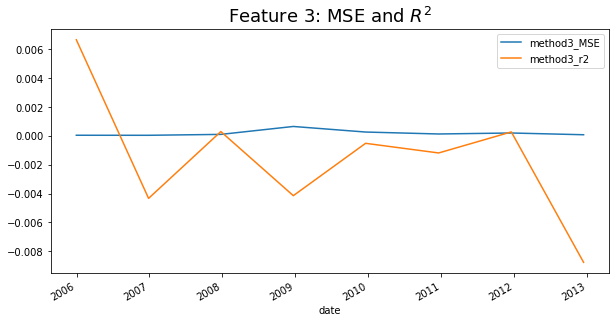

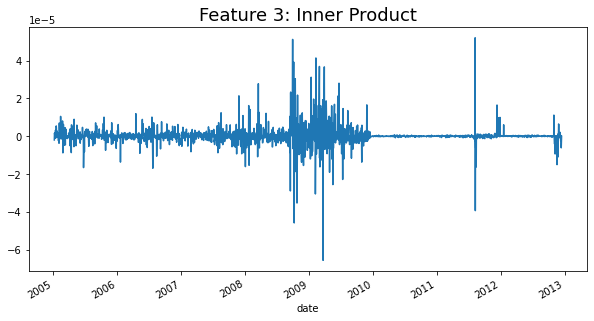

In [13]:
m_number = 3
w,k = "markets", 4
shift = 1
n_splits = 8


feature_name = "{}_diff_{}".format(w,k)


f, t = get_merged_ts(feature_df=trend_features,
                     feature_name=feature_name,
                     target_ts=target,
                     target_name=target_name)
f = f.shift(shift)
merged_df = pd.concat([f,t],1)
test_results3 = cv_lr_error_results(df=merged_df.dropna(),
                                    feature_name=feature_name,
                                    target_name=target_name,
                                    n_splits=n_splits)

results_over_time3 = get_results_over_time(test_results3, target_name)
results_over_time3 = results_over_time3.add_prefix("method{}_".format(m_number))

fig, ax = plt.subplots(figsize=(10,5))
results_over_time3.plot(ax=ax);
ax.set_title(r"Feature {}: MSE and $R^2$".format(m_number), fontsize=18);

inner_product3 = pd.concat([res.prod(1) for res in test_results3])
fig, ax = plt.subplots(figsize=(10,5))
inner_product3.plot(ax=ax);
ax.set_title("Feature {}: Inner Product".format(m_number), fontsize=18);

### 4) 

\begin{align}
(\text{method }4)& \quad &\hat{R}_t = \beta_0 + \beta_1 D^{\text{nasdaq}}_{6, \,t-2}
\end{align}


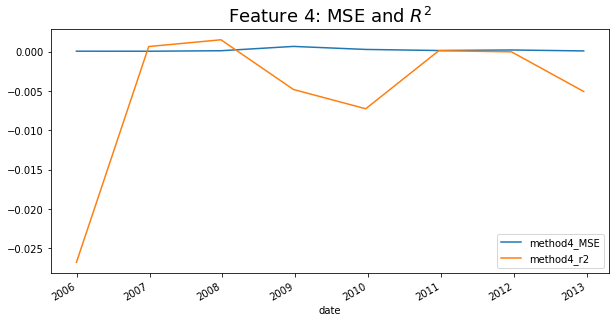

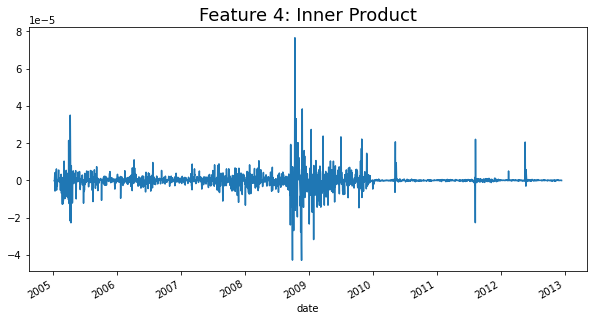

In [14]:
m_number = 4
w,k = "nasdaq", 6
shift = 2
n_splits = 8


feature_name = "{}_diff_{}".format(w,k)


f, t = get_merged_ts(feature_df=trend_features,
                     feature_name=feature_name,
                     target_ts=target,
                     target_name=target_name)
f = f.shift(shift)
merged_df = pd.concat([f,t],1)
test_results4 = cv_lr_error_results(df=merged_df.dropna(),
                                    feature_name=feature_name,
                                    target_name=target_name,
                                    n_splits=n_splits)

results_over_time4 = get_results_over_time(test_results4, target_name)
results_over_time4 = results_over_time4.add_prefix("method{}_".format(m_number))

fig, ax = plt.subplots(figsize=(10,5))
results_over_time4.plot(ax=ax);
ax.set_title(r"Feature {}: MSE and $R^2$".format(m_number), fontsize=18);

inner_product4 = pd.concat([res.prod(1) for res in test_results4])
fig, ax = plt.subplots(figsize=(10,5))
inner_product4.plot(ax=ax);
ax.set_title("Feature {}: Inner Product".format(m_number), fontsize=18);

## Comparison

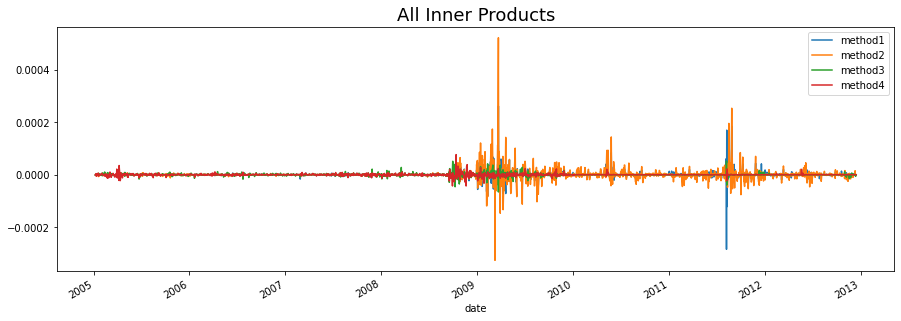

In [15]:
ip = pd.concat([inner_product1,inner_product2,
                inner_product3,inner_product4],1)
ip.columns = ["method1", "method2", "method3", "method4"]
fig, ax = plt.subplots(figsize=(15,5))
ip.plot(ax=ax);
ax.set_title("All Inner Products", fontsize=18);

In [16]:
ip.mean() / ip.std()

method1    0.027113
method2    0.035611
method3    0.031608
method4   -0.003844
dtype: float64